In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
import pandas as pd 
import matplotlib.pyplot as plt
import os 
from torch.utils.tensorboard import SummaryWriter
import numpy as np

/home/datnguyenthanh/datnt_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [2]:
m_path = '/home/tungnguyendinh/.fastai/data/pascal_2007/'
print(os.listdir(m_path))

['test.json', 'valid.json', 'train.csv', 'test.csv', 'train.json', 'segmentation', '.ipynb_checkpoints', 'test', 'train']


In [3]:
print(os.listdir(f"{m_path}/train"))

['000102.jpg', '008422.jpg', '002564.jpg', '007996.jpg', '002002.jpg', '007346.jpg', '001045.jpg', '000686.jpg', '004450.jpg', '005496.jpg', '000746.jpg', '006593.jpg', '007109.jpg', '006175.jpg', '001273.jpg', '005014.jpg', '005244.jpg', '005413.jpg', '007289.jpg', '007308.jpg', '004693.jpg', '007489.jpg', '003824.jpg', '007259.jpg', '005854.jpg', '003500.jpg', '005285.jpg', '008862.jpg', '004293.jpg', '002772.jpg', '002209.jpg', '004368.jpg', '005202.jpg', '004885.jpg', '003370.jpg', '003939.jpg', '009433.jpg', '001498.jpg', '001481.jpg', '003539.jpg', '002745.jpg', '001548.jpg', '002496.jpg', '003133.jpg', '000754.jpg', '006658.jpg', '000653.jpg', '001145.jpg', '006587.jpg', '000967.jpg', '002415.jpg', '000805.jpg', '001393.jpg', '003150.jpg', '003811.jpg', '008582.jpg', '007731.jpg', '006707.jpg', '003516.jpg', '003279.jpg', '007261.jpg', '005796.jpg', '000917.jpg', '002670.jpg', '008587.jpg', '006067.jpg', '007474.jpg', '003566.jpg', '001480.jpg', '003809.jpg', '004859.jpg', '0008

In [4]:
#Define classes and encode/decode functions

VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
)

def encode_label(labels, classes = VOC_CLASSES):
    target = torch.zeros(len(classes))
    for l in labels:
        idx = classes.index(l)
        target[idx] = 1
    return target

def decode_target(target, threshold = 0.5, classes = VOC_CLASSES):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            result.append(classes[i])
    return ' '.join(result)

In [5]:
from torchvision.io import read_image
#Create Custom dataset class for Pascal_2007
class PascalDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None, is_train = False, is_valid = False):
        self.img_labels = pd.read_csv(annotations_file)
        if is_train:
            self.img_labels = self.img_labels[~self.img_labels["is_valid"]]
        if is_valid:
            self.img_labels = self.img_labels[self.img_labels["is_valid"]]
            
                
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1].split(" ")
        if self.transform:
            image = self.transform(image)
        return image, encode_label(label)

device = ("cuda:0" if torch.cuda.is_available()
          else "cpu")

In [6]:
mean=[0.457342265910642, 0.4387686270106377, 0.4073427106250871]
std=[0.26753769276329037, 0.2638145880487105, 0.2776826934044154]  
#ImageNet values, recommended by PyTorch for normalizing images

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.RandomChoice([
                            transforms.ColorJitter(brightness=(0.9, 1.1)),
                            transforms.RandomGrayscale(p = 0.25)
                            ]),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.RandomRotation(25),
    transforms.ToTensor(), 
    transforms.Normalize(mean = mean, std = std),
    ])

eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])
train_data = PascalDataset(f"{m_path}/train", f"{m_path}/train.csv", transform=train_transform, is_train= True)
val_data = PascalDataset(f"{m_path}/train", f"{m_path}/train.csv", transform=eval_transform, is_valid = True)
test_data  = PascalDataset(f"{m_path}/test", f"{m_path}/test.csv", transform=eval_transform)

In [7]:
labels = pd.read_csv(f"{m_path}/train.csv")
labels = labels[~labels['is_valid']]['labels']
labels_tensor = torch.zeros((len(train_data), 20))
for i in range(len(train_data)):
   labels_tensor[i] = encode_label(labels.iloc[i].split(' '))
del labels
pos_counts = torch.sum(labels_tensor, dim = 0)
print(pos_counts) #Heavily imbalanced, 
print(VOC_CLASSES[torch.argmax(pos_counts)])  #Person is the object with highest number of classes

tensor([ 113.,  122.,  182.,   87.,  153.,  100.,  402.,  166.,  282.,   71.,
         130.,  210.,  144.,  123., 1070.,  153.,   49.,  188.,  128.,  144.])
person


In [8]:
# def calculating_class_weights(y_true):
#     from sklearn.utils.class_weight import compute_class_weight
#     number_dim = np.shape(y_true)[1]
#     weights = np.empty([number_dim, 2])
#     for i in range(number_dim):
#         weights[i] = compute_class_weight('balanced', classes =[0.,1.], y=y_true[:, i])
#     return weights

In [9]:
# class_weight = calculating_class_weights(labels_tensor.numpy())[:, 1]
# class_weight = torch.from_numpy(class_weight).to(device)
# class_weight

In [10]:
BATCH_SIZE = 16
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, BATCH_SIZE * 2)
test_loader  = DataLoader(test_data, BATCH_SIZE * 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


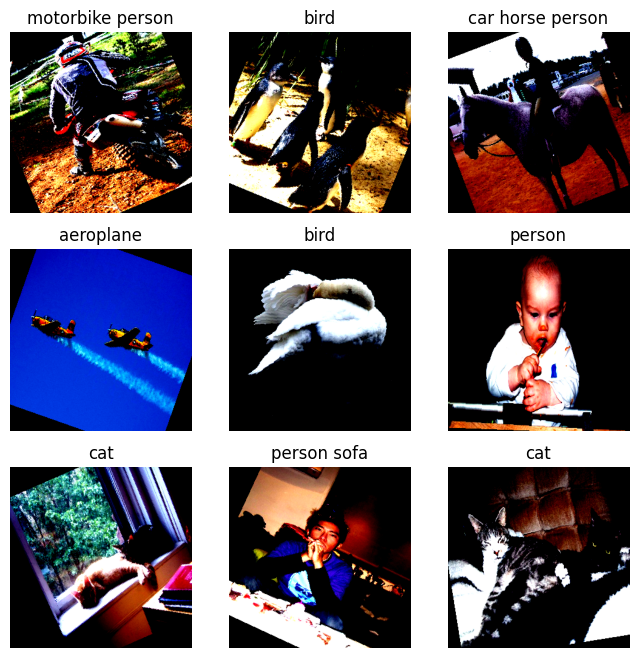

In [11]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    title = f"{decode_target(label)}" 
    plt.title(title) 
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
plt.show()

## Defining Model
I choose ResNet (particularly ResNet50) because it has shown its effectiveness on classification and its ability to deal with Vanishing Gradient. 
Also this is the best architecture that I can understand and implement from scratch.

In [12]:

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(
            out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        # downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        # add identity
        x += identity
        x = self.relu(x)

        return x


class Block(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = self.relu(x)
        return


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(
            num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(
            ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(
            ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(
            ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes,
                      i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)
    
def ResNet34(num_classes, channels=3):
    return ResNet(Block, [3, 4, 6, 3], num_classes, channels)

def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, channels)

model = ResNet50(20).to(device)

The kernel below is dedicated for initializing ResNet50 with pretrained weights (on ImageNet1k). If you wish to try it, comment the model initialization from previous kernel and uncomment the following kernel.

In [13]:
# from torchvision import models
# model = models.resnet50(pretrained=True)
# # for param in model.parameters():
# #         param.requires_grad = False
# model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
# model.fc = nn.Sequential(nn.Dropout(0.3),
#                          nn.Linear(model.fc.in_features, 20))
# model = model.to(device)

Here you might see 2 optimizers, the commented one is actually for the pretrained model. In case you want to test the pretrained model's performance, uncomment the optimizer and comment-out the current optimizer. 

In [14]:
# Initialize loss & optimizer
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')        #Change reduction to 'sum' if use pretrained model
# optimizer = torch.optim.SGD([   
#             {'params': list(model.parameters())[:-1], 'lr': 1e-4, 'momentum': 0.9},
#             {'params': list(model.parameters())[-1], 'lr': 5e-2, 'momentum': 0.9}
#             ])

optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

#Scheduler to automatically reduce learning rate at higher epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)


In [15]:
#Creating summary writer for logging loss, accuracy, hamming score to tensorboard
TRAIN = True    #This variable is to switch between training and loading model weights. If you run this notebook for the first time, set it to True
name = 'ResNet50_Pretrained_Standardized_exp'
if TRAIN:
    for i in range(20):
        if not os.path.exists(f'/home/datnguyenthanh/PyTorch_Training/runs/{name}{i}'):
            writer = SummaryWriter(f'runs/{name}{i}')
            name = f'{name}{i}'
            break
else:
    name = f'{name}{2}'

### Defining metrics
The goals of this project is Accuracy > 92%. Accuracy of multilabel classification is defined by proportion of element-wise exact matches. For example, let [0, 1, 0] and [0, 0, 0] be the predictions and ground_truth, the accuracy would be 66%. As such, in scenario of 20 classes to predict, the accuracy can gets really high, and so I decided to include another measure (i.e Hamming Score) that represents the model's performance better.

In [16]:
from sklearn.metrics import accuracy_score
import numpy as np


def Accuracy_n_HammingScore(y_pred, y_true):
    y_pred = torch.round(y_pred)
    label = np.asarray(y_true.cpu())
    prob = np.asarray(y_pred.cpu())
    batch_size = label.shape[0]
    acc = 0
    hl = 0
    for i in range(batch_size):
        acc += accuracy_score(prob[i], label[i], normalize=True)
        hl += sum(torch.logical_and(
            y_true[i], y_pred[i])) / sum(torch.logical_or(y_true[i], y_pred[i]))
    acc /= batch_size
    hl /= batch_size
    return acc, hl

In [17]:
def train(dataloader, model, loss_fn, optimizer, epoch, writer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch % 50 == 0):
            loss, current = loss.item(), (batch + 1) * len(X)
            tmp_pred = nn.Sigmoid()(pred).detach()
            tmp_y = y.detach()
            curr_acc, curr_hl = Accuracy_n_HammingScore(y_pred=tmp_pred, y_true=tmp_y)
            del tmp_pred, tmp_y
            print(f"loss: {loss:>7f}, training accuracy: {100*curr_acc:>0.1f}%, hamming score: {100*curr_hl:>0.1f}% Data: [{current:>5d}/{size:>5d}]")
    eval(train_loader, model, loss_fn, epoch, mode = "train", writer = writer)
    

            


def eval(dataloader, model, loss_fn, epoch, mode = "test", writer = None):
    num_batches = len(dataloader)
    model.eval()
    eval_loss, hl, acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            eval_loss += loss_fn(out, y).item()
            out = nn.Sigmoid()(out)
            tmp_acc, tmp_hl = Accuracy_n_HammingScore(y_pred=out, y_true=y)
            hl += tmp_hl
            acc += tmp_acc
            del tmp_hl, tmp_acc
    eval_loss /= num_batches
    hl /= num_batches  # Accuracy for whole epoch
    acc /= num_batches
    print(f"{mode} Error: \n Accuracy: {(100*acc):>0.1f}%, hamming score: {100*hl:>0.1f}%, Avg loss: {eval_loss:>8f} \n")
    if writer:
        writer.add_scalar(f'Loss/{mode}', eval_loss, epoch)
        writer.add_scalar(f'Accuracy/{mode}', acc, epoch)
        writer.add_scalar(f'HammingScore/{mode}', hl, epoch)



In [27]:
if TRAIN:
    epochs = 40
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer, t, writer)
        writer.add_scalar(f'Learning_rate', scheduler.get_last_lr()[0], t)
        scheduler.step()
        eval(val_loader, model, loss_fn, t, mode = 'validation', writer = writer)
    print("Done!")
    torch.save(model.state_dict(), f'runs/{name}/model.pth')
else:
    model.load_state_dict(torch.load(f'runs/{name}/model.pth'))
    eval(val_loader, model, loss_fn, 0, mode = 'validation')

Epoch 41
-------------------------------
loss: 0.167423, training accuracy: 93.4%, hamming score: 11.5% Data: [   16/ 2501]
loss: 0.167025, training accuracy: 93.1%, hamming score: 35.4% Data: [  816/ 2501]
loss: 0.174789, training accuracy: 94.1%, hamming score: 22.9% Data: [ 1616/ 2501]
loss: 0.185568, training accuracy: 93.4%, hamming score: 28.6% Data: [ 2416/ 2501]
train Error: 
 Accuracy: 93.4%, hamming score: 29.6%, Avg loss: 0.175980 

validation Error: 
 Accuracy: 92.8%, hamming score: 25.2%, Avg loss: 0.198549 

Epoch 42
-------------------------------
loss: 0.204504, training accuracy: 92.8%, hamming score: 15.6% Data: [   16/ 2501]
loss: 0.194232, training accuracy: 92.5%, hamming score: 18.2% Data: [  816/ 2501]
loss: 0.221903, training accuracy: 92.5%, hamming score: 19.3% Data: [ 1616/ 2501]
loss: 0.207069, training accuracy: 92.8%, hamming score: 40.0% Data: [ 2416/ 2501]
train Error: 
 Accuracy: 93.2%, hamming score: 27.5%, Avg loss: 0.179615 

validation Error: 
 Accu

KeyboardInterrupt: 

## Testing model's performance on test data
Here you might see that even when the model (from scratch) has high accuracy (92%+), it still performs poorly. This is because accuracy for multilabel is calculated as EXACT MATCH for prediction, which means even when the model predict the absence of an object (i.e doesn't predict), it is still contributed to the accuracy. Hence, I include another measurement (i.e Hamming Score) to measure the ability to correctly predict presence of a class.

Note: I have testsed the model with pretrained weights on ImageNet1k, the Hamming Score is very good (75%+), so I believe ResNet50 from scratch may not be good enough for this particular problem, and having pretrained weights would help extracting features better for multilabel.

Note2: In the code above I have included a version of pretrained model, you could try it yourself

In [19]:
model.eval()
eval_loss, correct = 0, 0
i = 0
low_acc_lst = None
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        out = nn.Sigmoid()(out)
        if i == 0:
            low_acc_lst = out
        else:
            low_acc_lst = torch.cat((low_acc_lst, out))    
        i += 1
        if i == 50:
            break
inv_normalize = transforms.Normalize(
    mean= [-m for m in mean],
    std= [1/s for s in std]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


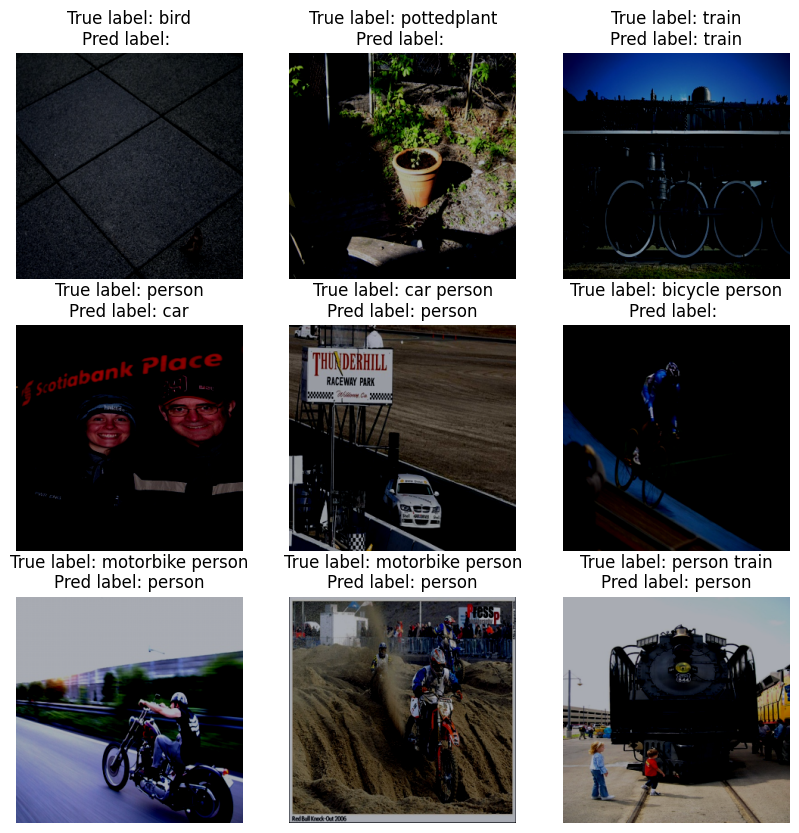

In [20]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(low_acc_lst), size=(1,)).item()
    img, label = test_data[sample_idx]
    img, label = img.to("cpu"), label.to("cpu")
    img = inv_normalize(img)
    figure.add_subplot(rows, cols, i)
    true_label = decode_target(label)
    pred_label = decode_target(low_acc_lst[sample_idx])
    title = f"True label: {true_label}\nPred label: {pred_label}"
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
plt.show()

## Filter visualization
The following code will demostrate 2 things:
1. Features visualization: I will visualize what features does the first convolution layer pickup
2. Features map: I will pass 1 example image to and visualize different layers' outputs

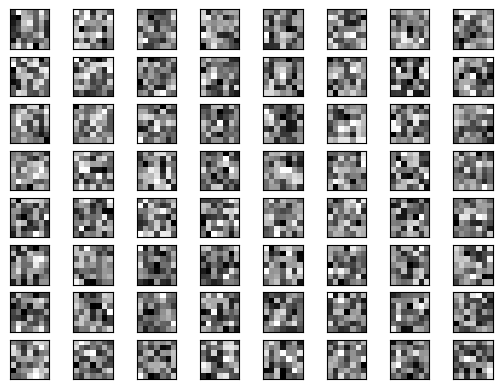

In [21]:
def imshow_filter(img,row,col):
    plt.figure()
    for i in range(len(filters)):
        w = np.array([0.299, 0.587, 0.114]) #weight for RGB
        img = filters[i]
        img = np.transpose(img, (1, 2, 0))
        img = img/(img.max()-img.min())
        img = np.dot(img,w)

        plt.subplot(row,col,i+1)
        plt.imshow(img,cmap= 'gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()
filters = model.conv1.weight.data.cpu().numpy()
imshow_filter(filters,8,8)

In [22]:
model_weights =[]
conv_layers = []
# get all the model children as list
model_children = list(model.children())
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 49
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)), Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)), Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)), Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)), Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1)), Conv2d(512, 128, kernel_size=(

In [23]:
outputs = []
names = []
image, label = train_data[0]
image = image[None, :].to(device)
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps shape
for feature_map in outputs:
    print(feature_map.shape)

49
torch.Size([1, 64, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 256, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 256, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 64, 150, 150])
torch.Size([1, 256, 150, 150])
torch.Size([1, 128, 150, 150])
torch.Size([1, 128, 75, 75])
torch.Size([1, 512, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 512, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 512, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 128, 75, 75])
torch.Size([1, 512, 75, 75])
torch.Size([1, 256, 75, 75])
torch.Size([1, 256, 38, 38])
torch.Size([1, 1024, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 1024, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 1024, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 256, 38, 38])
torch.Size([1, 1024, 3

In [24]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(150, 150)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(75, 75)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(38, 38)
(19, 19)
(19, 19)
(19, 19)
(19, 19)
(19, 19)
(19, 19)
(19, 19)
(19, 19)


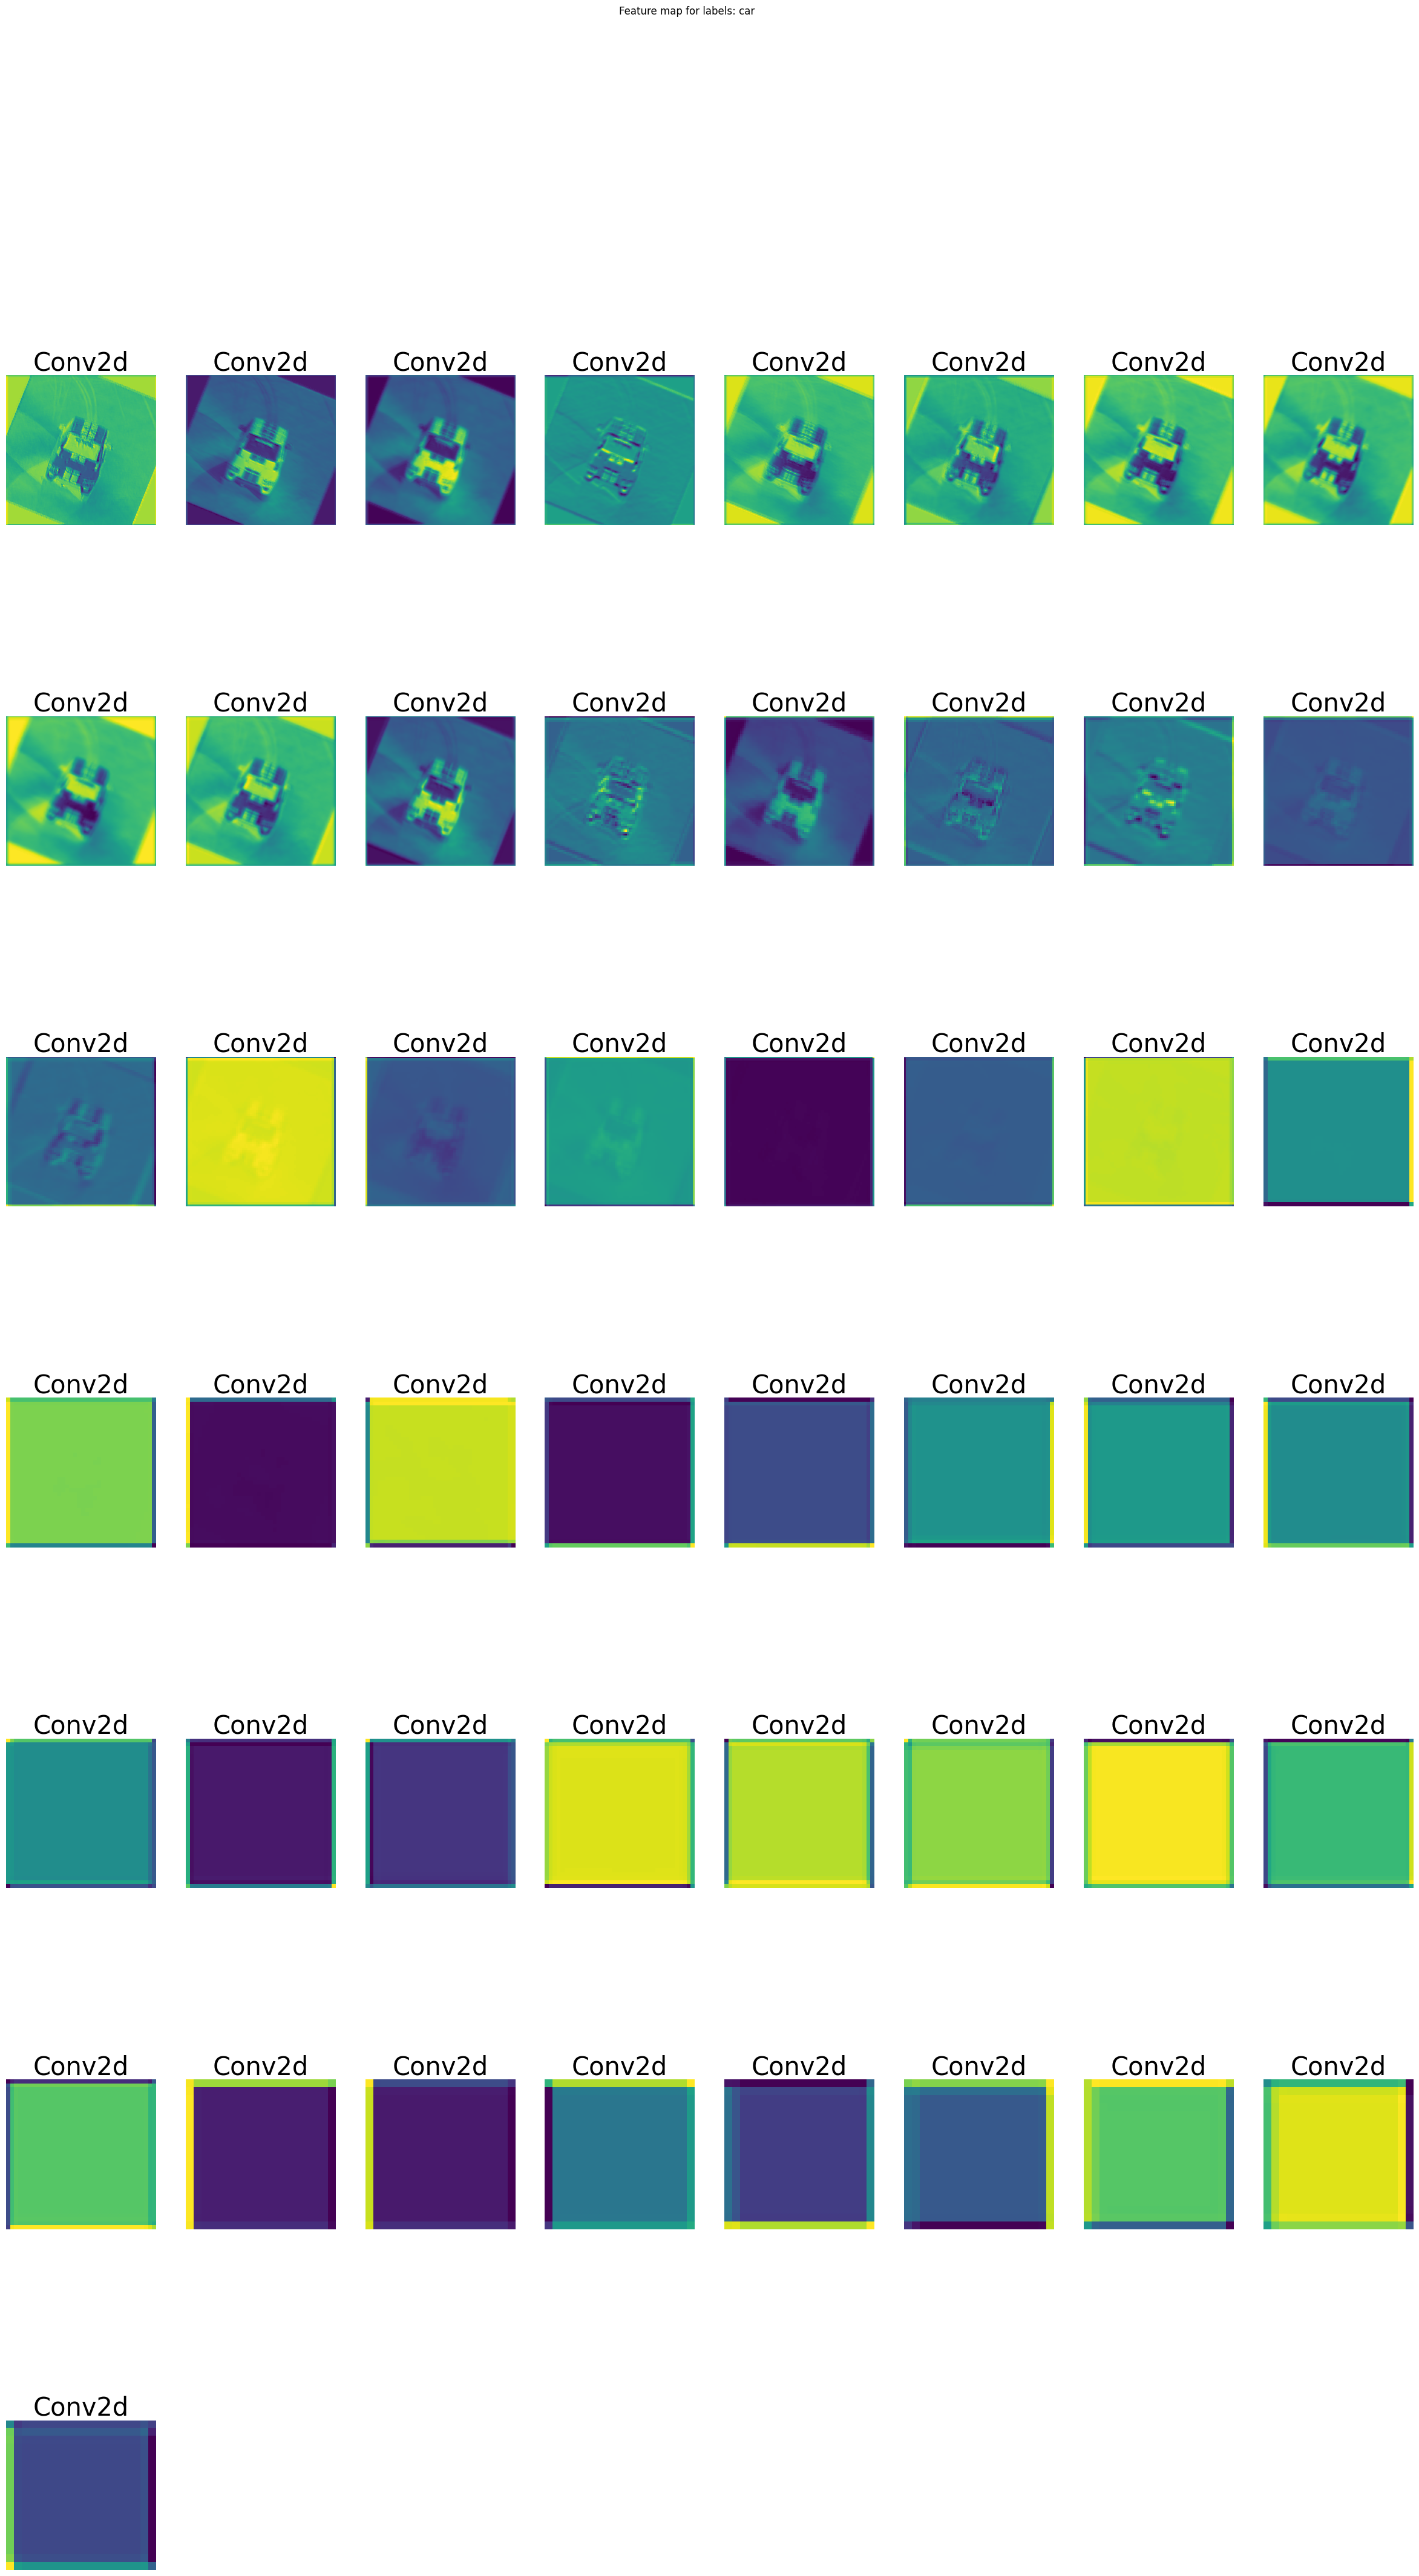

In [29]:
fig = plt.figure(figsize=(30, 50))
fig.suptitle(f"Feature map for labels: {decode_target(label)}", fontsize=70)
for i in range(len(processed)):
    a = fig.add_subplot(7, 8, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)


Here I observe a very interesting phenomenom. The features in later layers completely disappear. On the other hand, outputs returned by pretrained model will have some noise indicating part of image the model focus on. 

### gradCAM
Here I tried to implement Class Activation Mapping for model but failed miserably. Will try again in another time

In [26]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

# class SigmoidOutputTarget:
#     def __init__(self):
#         pass

#     def __call__(self, model_output):
#         return nn.Sigmoid()(model_output)

# target_layers = [model.layer4[-1]]
# #input_tensor = next(iter(val_loader))[0][0].to(device)
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
# targets = [ClassifierOutputTarget(19)]

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor[None, :], targets=targets)
# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)